In [2]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


In [4]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


슝=3


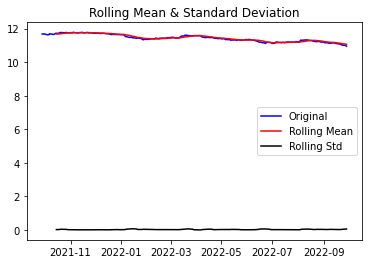

Results of Dickey-Fuller Test:
Test Statistic                   0.183315
p-value                          0.971310
#Lags Used                       3.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -4.736399
p-value                          0.000072
#Lags Used                       3.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


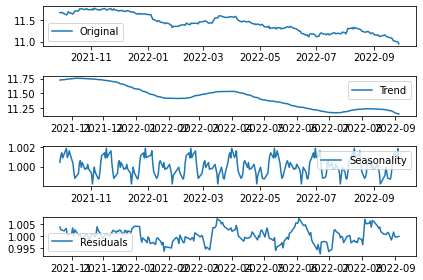

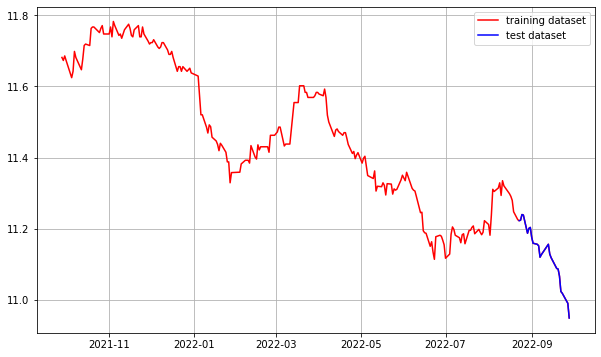

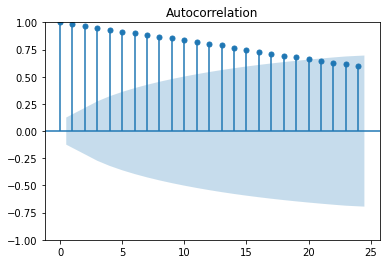

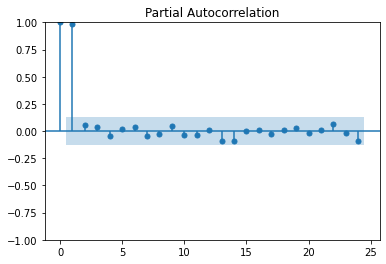

Results of Dickey-Fuller Test:
Test Statistic                -7.908458e+00
p-value                        4.007365e-12
#Lags Used                     2.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                ARIMA(10, 1, 0)   Log Likelihood                 513.031
Date:                Wed, 28 Sep 2022   AIC                          -1004.063
Time:                        11:36:37   BIC                           -966.733
Sample:                             0   HQIC                          -988.988
                                - 221                                         
Covariance Type:                  opg                                         
              

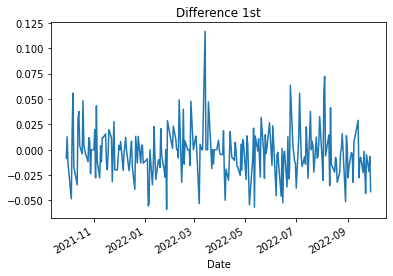

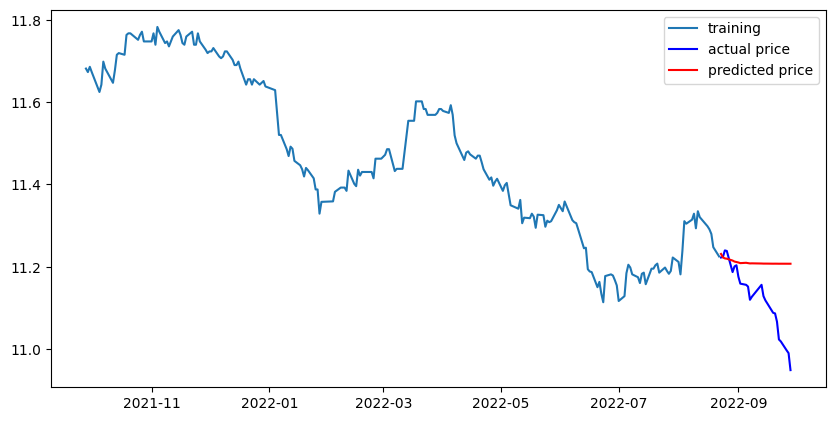

MSE:  59757732.905088656
MAE:  6083.28822809439
RMSE:  7730.312600735409
MAPE: 9.56%


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

print('슝=3')
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/035720.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

# 로그 변환
ts_log = np.log(ts)

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

# 학습, 테스트 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')


# augmented_dickey_fuller_test(diff_2)

# ARIMA모델 훈련과 테스트
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(10, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


슝=3


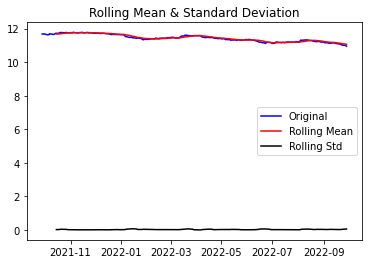

Results of Dickey-Fuller Test:
Test Statistic                   0.183315
p-value                          0.971310
#Lags Used                       3.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -4.736399
p-value                          0.000072
#Lags Used                       3.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


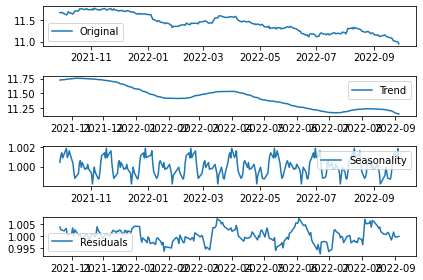

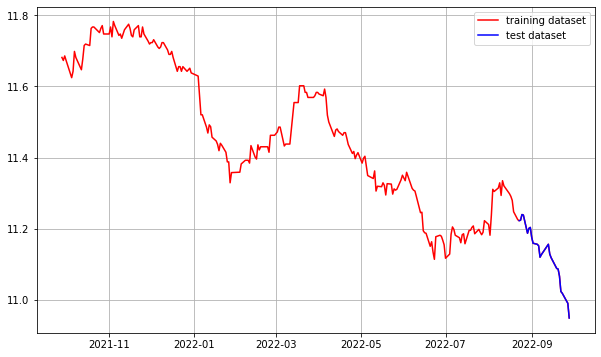

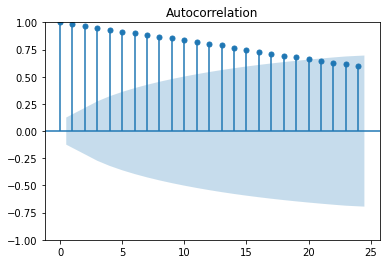

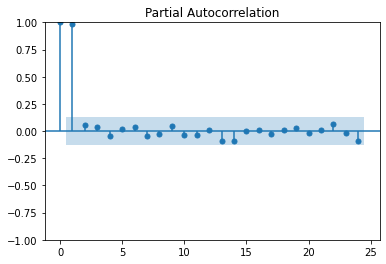

Results of Dickey-Fuller Test:
Test Statistic                -7.908458e+00
p-value                        4.007365e-12
#Lags Used                     2.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                ARIMA(14, 1, 2)   Log Likelihood                 513.827
Date:                Wed, 28 Sep 2022   AIC                           -993.653
Time:                        11:37:40   BIC                           -935.961
Sample:                             0   HQIC                          -970.356
                                - 221                                         
Covariance Type:                  opg                                         
              

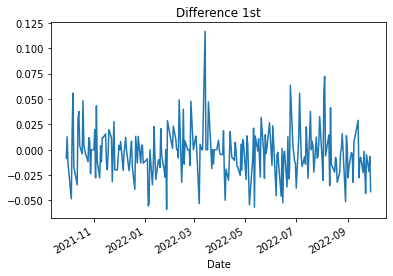

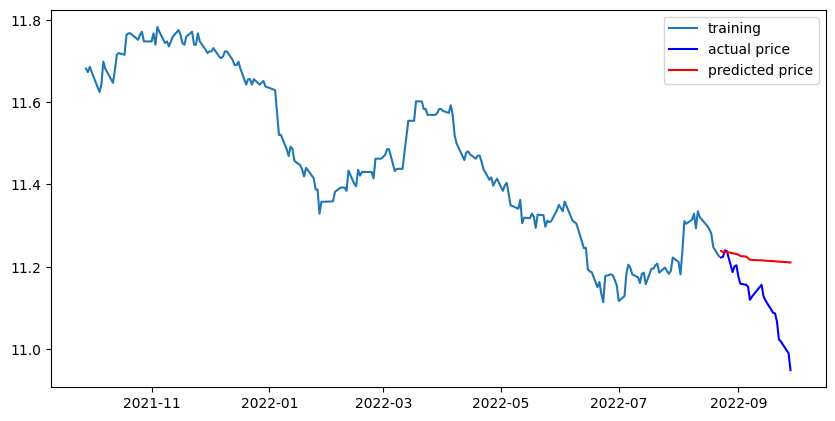

MSE:  66045058.32662231
MAE:  6649.152800097399
RMSE:  8126.811079791526
MAPE: 10.39%


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

print('슝=3')
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/035720.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

# 로그 변환
ts_log = np.log(ts)

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

# 학습, 테스트 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')


# augmented_dickey_fuller_test(diff_2)

# ARIMA모델 훈련과 테스트
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(14, 1, 2))  
fitted_m = model.fit() 

print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


슝=3


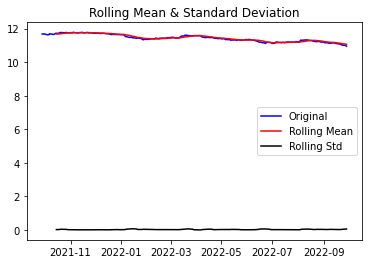

Results of Dickey-Fuller Test:
Test Statistic                   0.183315
p-value                          0.971310
#Lags Used                       3.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -4.736399
p-value                          0.000072
#Lags Used                       3.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


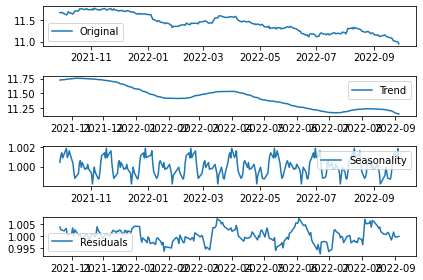

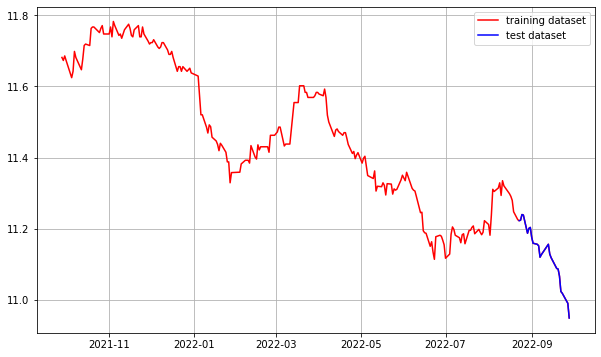

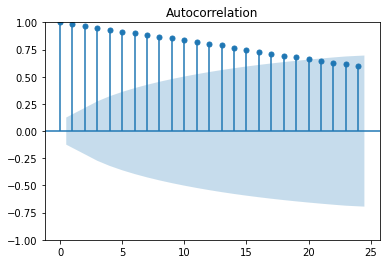

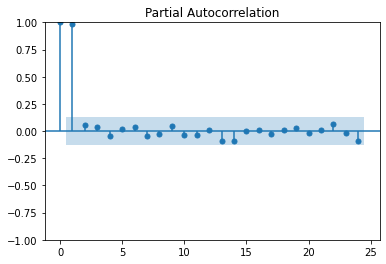

Results of Dickey-Fuller Test:
Test Statistic                -7.908458e+00
p-value                        4.007365e-12
#Lags Used                     2.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                ARIMA(25, 1, 7)   Log Likelihood                 518.964
Date:                Wed, 28 Sep 2022   AIC                           -971.928
Time:                        11:38:08   BIC                           -859.938
Sample:                             0   HQIC                          -926.703
                                - 221                                         
Covariance Type:                  opg                                         
              

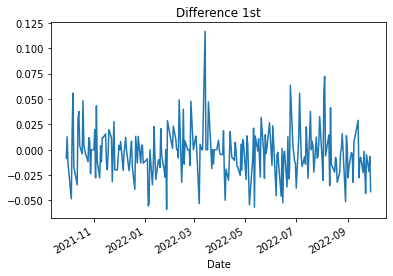

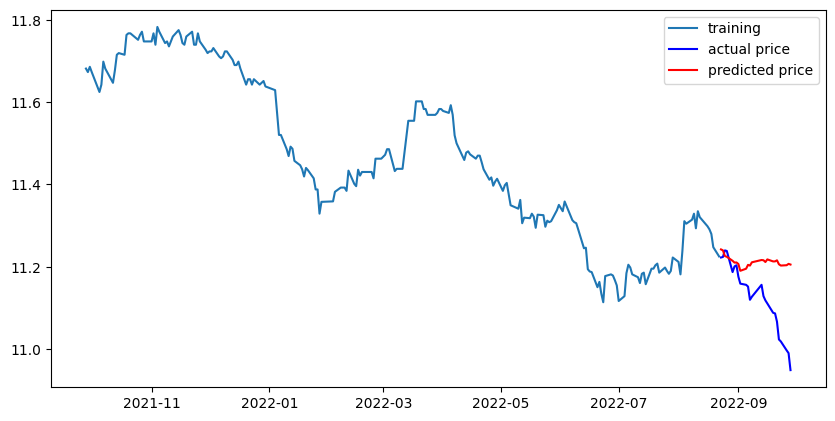

MSE:  60115238.38627594
MAE:  6103.854163526657
RMSE:  7753.401729968333
MAPE: 9.59%


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

print('슝=3')
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/035720.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

# 로그 변환
ts_log = np.log(ts)

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

# 학습, 테스트 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')


# augmented_dickey_fuller_test(diff_2)

# ARIMA모델 훈련과 테스트
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(25, 1, 7))  
fitted_m = model.fit() 

print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))
